In [22]:
# import the necessary packages
from sklearn.neighbors import KNeighborsClassifier
from sklearn import cross_validation
from imutils import paths
import numpy as np
import pandas as pd
import argparse
import imutils
import cv2
import os
import math
from sklearn.decomposition import PCA

from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as PLT
import itertools
%matplotlib inline
import seaborn as sns
sns.set_style("whitegrid", {'axes.grid' : False})

In [28]:
def image_to_feature_vector(image, size=(64, 64)):
	# resize the image to a fixed size, then flatten the image into
	# a list of raw pixel intensities
    image = cv2.resize(image, size)
    return cv2.cvtColor(image, cv2.COLOR_BGR2GRAY).flatten()

In [3]:
def extract_color_histogram(image, bins=(8, 8, 8)):
	# extract a 3D color histogram from the HSV color space using
	# the supplied number of `bins` per channel
	hsv = cv2.cvtColor(image, cv2.COLOR_BGR2HSV)
	hist = cv2.calcHist([hsv], [0, 1, 2], None, bins,
		[0, 180, 0, 256, 0, 256])

	# handle normalizing the histogram if we are using OpenCV 2.4.X
	if imutils.is_cv2():
		hist = cv2.normalize(hist)

	# otherwise, perform "in place" normalization in OpenCV 3 (I
	# personally hate the way this is done
	else:
		cv2.normalize(hist, hist)

	# return the flattened histogram as the feature vector
	return hist.flatten()

======================================================================================================
# Load and Cleanup Data
======================================================================================================

In [4]:
dataset = "./classes/kNN_data/"
# grab the list of images that we'll be describing
print("[INFO] describing images...")
imagePaths = list(paths.list_images(dataset))
print "[INFO] " + str(len(list(paths.list_images(dataset)))) + " images found!"

[INFO] describing images...
[INFO] 6000 images found!


In [29]:
# initialize the raw pixel intensities matrix, the features matrix,
# and labels list
rawImages = []
features = []
labels = []

# loop over the input images
for (i, imagePath) in enumerate(imagePaths):
	# load the image and extract the class label (assuming that our
	# path as the format: /path/to/dataset/{class}.{image_num}.jpg
	image = cv2.imread(imagePath)
	label = imagePath.split(os.path.sep)[-1].split(".")[0]

	# extract raw pixel intensity "features", followed by a color
	# histogram to characterize the color distribution of the pixels
	# in the image
	pixels = image_to_feature_vector(image)
	hist = extract_color_histogram(image)

	# update the raw images, features, and labels matricies,
	# respectively
	rawImages.append(pixels)
	features.append(hist)
	labels.append(label)

	# show an update every 1,000 images
	if i > 0 and i % 1000 == 0:
		print("[INFO] processed {}/{}".format(i, len(imagePaths)))

[INFO] processed 1000/6000
[INFO] processed 2000/6000
[INFO] processed 3000/6000
[INFO] processed 4000/6000
[INFO] processed 5000/6000


In [30]:
from collections import Counter
Counter(labels)

Counter({'adidas': 1500, 'jordan': 1500, 'newbalance': 1500, 'nike': 1500})

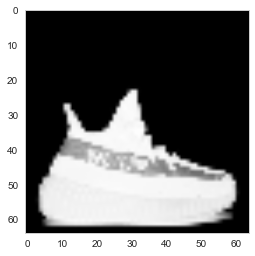

In [41]:
PLT.imshow(rawImages[0].reshape(64,64))


In [42]:
## Get 10 principal components
pca = PCA(n_components=10)
pca.fit(rawImages)
images_transformed = pca.transform(rawImages)

0.66072295347772869

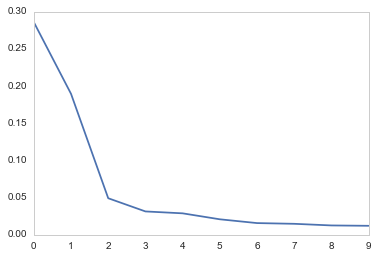

In [43]:
plt.plot(pca.explained_variance_ratio_)
sum(pca.explained_variance_ratio_)

In [48]:
from time import time
# rawImages
adidas = rawImages[0:1500]
jordan = rawImages[1500:3000]
newbalance = rawImages[3000:4500]
nike = rawImages[4500:6000]

n_components = 10

a = np.array(adidas)
j = np.array(jordan)
nb = np.array(newbalance)
nk = np.array(nike)

pca_adidas = PCA(n_components=n_components).fit(a)
pca_jordan = PCA(n_components=n_components).fit(j)
pca_newbalance = PCA(n_components=n_components).fit(nb)
pca_nike = PCA(n_components=n_components).fit(nk)

In [49]:
pca_adidas.transform(adidas)

array([[-3160.62605949, -4197.39608837, -2142.86575658, ...,
         -871.5973305 ,   574.9438127 ,  -259.48422261],
       [ 2775.01597509,  -222.80101222,  -402.27154617, ...,
         -230.80909595,  -114.44521692,   206.29013765],
       [-1205.93464712,  1329.3851348 ,   356.5890468 , ...,
         -248.3232063 ,   -86.41866103,   205.05382439],
       ..., 
       [ 1309.76260213,  1369.72379627,  -621.39245177, ...,
          242.12163784,    72.88583336,   149.95383638],
       [ 1602.08776446,   623.86294114,   246.03065676, ...,
         -603.43932788,  -621.27187625,   128.54000704],
       [ 1411.63877208,    34.25006962,   189.93752503, ...,
          334.51698567,   175.95200233,  -104.21184622]])

===================================================================================================================
# Visualizing Principal Components
===================================================================================================================

(40, 64, 64)


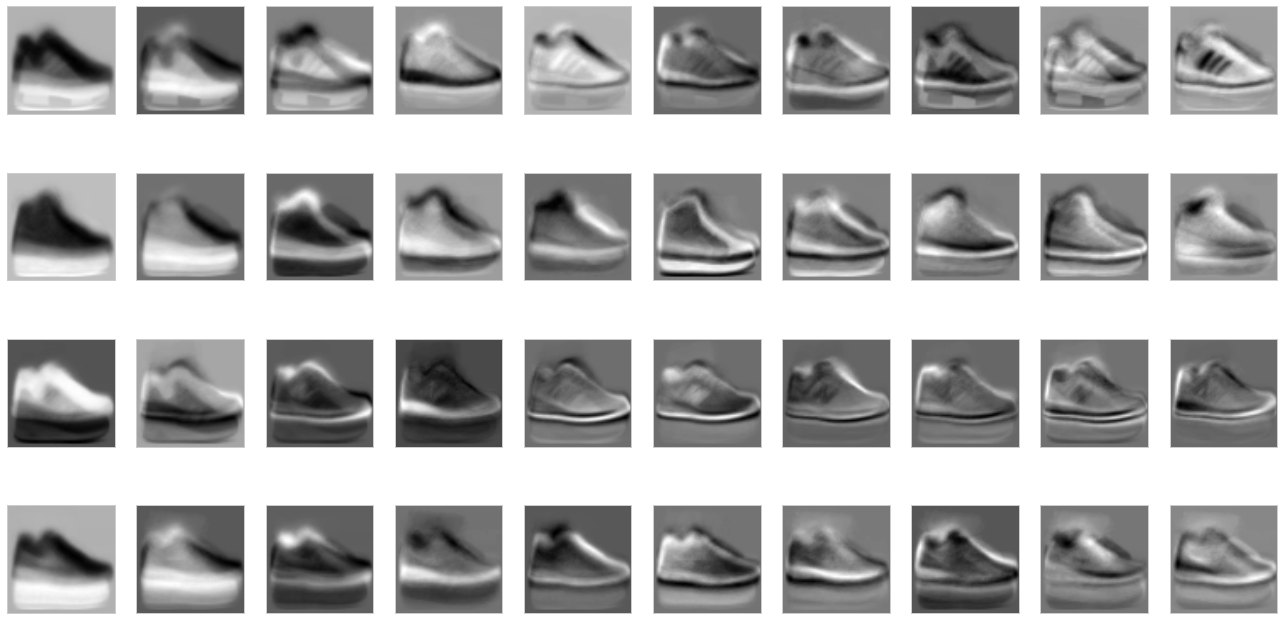

In [54]:
n_row=4
n_col=10
plt.figure(figsize=(1.8 * n_col, 2.4 * n_row))
plt.subplots_adjust(bottom=0, left=.01, right=.99, top=.90, hspace=.35)

img = pca_adidas.components_.reshape(10,64,64)
img2 = pca_jordan.components_.reshape(10,64,64)
img3 = pca_newbalance.components_.reshape(10,64,64)
img4 = pca_nike.components_.reshape(10,64,64)

final = np.append(img,img2)
final = np.append(final,img3)
final = np.append(final,img4)

final = final.reshape(40,64,64)
print final.shape

for i in range(n_row * n_col):
    plt.subplot(n_row, n_col, i + 1)
    plt.imshow(final[i], cmap=plt.cm.gray)
    plt.xticks(())
    plt.yticks(())


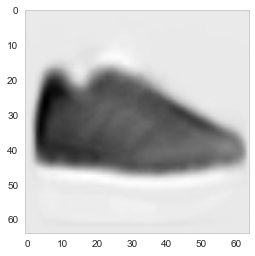

In [56]:
transformed_adidas = pca_adidas.transform(adidas)
adidas_i = pca_adidas.inverse_transform(transformed_adidas).reshape(1500,64,64)

testerino = np.array(pca_adidas.inverse_transform(transformed_adidas[200]).reshape(64,64), dtype=int)
testerino
PLT.imshow(testerino, cmap=plt.cm.gray)

========================================================================================================
# EigenShoes
========================================================================================================

In [438]:
import os
import scipy
import scipy.misc

import numpy as np
import numpy.linalg as lin

ad = np.array(rawImages)
ad_mean = np.array(rawImages).mean(0)

subtracted = map(lambda x: x-ad_mean, ad)
arr = np.array(subtracted)

## compute SVD of the data matrix
print "Computing sparse SVD of data matrix"
U, V, T = lin.svd(arr.transpose(), full_matrices=False)

# print eigenfaces to files
print "Writing eigenvectors to disk..."
for i in xrange(10):
   scipy.misc.imsave('eigenface_' + str(i) + '.png', U[:,i].reshape(64,64,3))

Computing sparse SVD of data matrix
Writing eigenvectors to disk...


In [437]:
np.array(rawImages).shape

(6000, 12288)

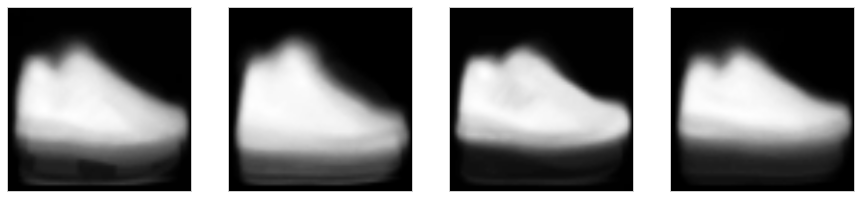

In [57]:
## Average Shoes
n_row=1
n_col=4
plt.figure(figsize=(3 * n_col, 4 * n_row))
plt.subplots_adjust(bottom=0, left=.01, right=.99, top=.90, hspace=.35)

mean_adidas = np.array(np.array(adidas).mean(0), dtype=int)
mean_jordan = np.array(np.array(jordan).mean(0), dtype=int)
mean_newbalance = np.array(np.array(newbalance).mean(0), dtype=int)
mean_nike = np.array(np.array(nike).mean(0), dtype=int)


final = np.append(mean_adidas,mean_jordan)
final = np.append(final,mean_newbalance)
final = np.append(final,mean_nike)

final = final.reshape(4,64,64)

for i in range(n_row * n_col):
    plt.subplot(n_row, n_col, i + 1)
    plt.imshow(final[i])
    plt.xticks(())
    plt.yticks(())
